In [1]:
import pandas as pd #make data-frames and summarise data
import numpy as np #manipulate multi-dimensional arrays
import os as os #file system read
import matplotlib.pyplot as plt #visualisation
import seaborn as sns
from scipy import stats #stats tests
from sklearn import preprocessing
from sklearn.cluster import KMeans
from scipy.stats import ttest_ind 
from scipy.stats import fisher_exact

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

In [2]:
ecmodf = pd.read_csv('ecmo.csv', index_col=0)
ecmodf = ecmodf.drop(columns=['sx_v', 'neut', 'cr'])
print(ecmodf.isnull().sum()) #count null values

age         0
bmi         0
ed_v        1
v_vv        0
sofa        0
pfr         4
pco2        6
pplat       6
lymph       0
nlrat       0
pct         1
ferritin    0
crp         0
fib         0
ddim        1
dtype: int64


## Iterative round robin regression imputation maintains original clusters

In [3]:
imp = IterativeImputer(verbose=2, max_iter=20, min_value=0)
ecmodf_impute = ecmodf.copy()
imp.fit(ecmodf_impute)

[IterativeImputer] Completing matrix with shape (56, 15)
[IterativeImputer] Ending imputation round 1/20, elapsed time 0.02
[IterativeImputer] Change: 6.933892399837763, scaled tolerance: 38.053 
[IterativeImputer] Early stopping criterion reached.


IterativeImputer(add_indicator=False, estimator=None,
                 imputation_order='ascending', initial_strategy='mean',
                 max_iter=20, max_value=None, min_value=0, missing_values=nan,
                 n_nearest_features=None, random_state=None,
                 sample_posterior=False, skip_complete=False, tol=0.001,
                 verbose=2)

In [4]:
ecmodf = pd.DataFrame(imp.transform(ecmodf_impute), columns = ecmodf.columns, index = ecmodf.index)

[IterativeImputer] Completing matrix with shape (56, 15)
[IterativeImputer] Ending imputation round 1/1, elapsed time 0.00


In [5]:
print(ecmodf.isnull().sum())

age         0
bmi         0
ed_v        0
v_vv        0
sofa        0
pfr         0
pco2        0
pplat       0
lymph       0
nlrat       0
pct         0
ferritin    0
crp         0
fib         0
ddim        0
dtype: int64


In [6]:
ecmodf['bmi'] = ecmodf['bmi'].astype('int64')
ecmodf.head()

,age,bmi,ed_v,v_vv,sofa,pfr,pco2,pplat,lymph,nlrat,pct,ferritin,crp,fib,ddim
id,,,,,,,,,,,,,,,
1,46.0,34,3.0,2.0,4.0,48.750000,6.00000,29.000000,0.4,24.0,0.800000,1609.0,306.0,7.2,10.3
2,34.0,37,6.0,1.0,4.0,76.500000,10.04465,29.513452,0.5,31.2,5.709137,115.0,217.0,4.1,80.0
3,66.0,26,6.0,1.0,10.0,61.578947,7.55000,28.000000,0.3,19.3,6.290000,5534.0,409.0,7.1,80.0
4,34.0,36,0.0,2.0,6.0,72.187500,7.10000,30.000000,1.9,9.6,1.210000,267.0,388.0,7.1,7.4
5,53.0,42,1.0,2.0,12.0,80.833333,9.30000,31.000000,0.8,7.4,100.000000,6023.0,665.0,5.9,73.3


In [7]:
ecmodf_norm = ecmodf.copy()

ecmodf_norm['ddim'] = np.log(ecmodf_norm['ddim']) #log conversion of skewed variables - days and sofa not included as would not expected to conform to a power law distribution
ecmodf_norm['ferritin'] = np.log(ecmodf_norm['ferritin'])
ecmodf_norm['pct'] = np.log(ecmodf_norm['pct'])
ecmodf_norm['nlrat'] = np.log(ecmodf_norm['nlrat'])
ecmodf_norm['lymph'] = np.log(ecmodf_norm['lymph'])
ecmodf_norm['pplat'] = np.log(ecmodf_norm['pplat'])
ecmodf_norm['pco2'] = np.log(ecmodf_norm['pco2'])
ecmodf_norm['bmi'] = np.log(ecmodf_norm['bmi'])
ecmodf_norm['sofa'] = np.log(ecmodf_norm['sofa'])

ecmodf_norm.head()

,age,bmi,ed_v,v_vv,sofa,pfr,pco2,pplat,lymph,nlrat,pct,ferritin,crp,fib,ddim
id,,,,,,,,,,,,,,,
1,46.0,3.526361,3.0,2.0,1.386294,48.750000,1.791759,3.367296,-0.916291,3.178054,-0.223144,7.383368,306.0,7.2,2.332144
2,34.0,3.610918,6.0,1.0,1.386294,76.500000,2.307040,3.384846,-0.693147,3.440418,1.742068,4.744932,217.0,4.1,4.382027
3,66.0,3.258097,6.0,1.0,2.302585,61.578947,2.021548,3.332205,-1.203973,2.960105,1.838961,8.618666,409.0,7.1,4.382027
4,34.0,3.583519,0.0,2.0,1.791759,72.187500,1.960095,3.401197,0.641854,2.261763,0.190620,5.587249,388.0,7.1,2.001480
5,53.0,3.737670,1.0,2.0,2.484907,80.833333,2.230014,3.433987,-0.223144,2.001480,4.605170,8.703341,665.0,5.9,4.294561


In [8]:
normalize = preprocessing.MinMaxScaler(feature_range=(0.01, 1.01))
ecmodf_normalized = normalize.fit_transform(ecmodf_norm)
ecmodf_normalized = pd.DataFrame(ecmodf_normalized)
ecmodf_normalized.columns = ecmodf_norm.columns
ecmodf_normalized.head()

,age,bmi,ed_v,v_vv,sofa,pfr,pco2,pplat,lymph,nlrat,pct,ferritin,crp,fib,ddim
0,0.510,0.516065,0.282727,0.260,0.010000,0.164412,0.053777,0.648269,0.311030,0.669388,0.267444,0.503267,0.461908,0.485610,0.505096
1,0.210,0.614365,0.555455,0.135,0.010000,0.572500,0.288401,0.671757,0.407940,0.743612,0.569678,0.080622,0.326031,0.107561,1.010000
2,1.010,0.204203,0.555455,0.135,0.670964,0.353073,0.158407,0.601307,0.186091,0.607728,0.584579,0.701147,0.619160,0.473415,1.010000
3,0.210,0.582513,0.010000,0.260,0.302481,0.509081,0.130426,0.693640,0.987724,0.410162,0.331078,0.215550,0.587099,0.473415,0.423650
4,0.685,0.761716,0.100909,0.260,0.802481,0.636225,0.253328,0.737523,0.612060,0.336526,1.010000,0.714711,1.010000,0.327073,0.988456


## general metrics

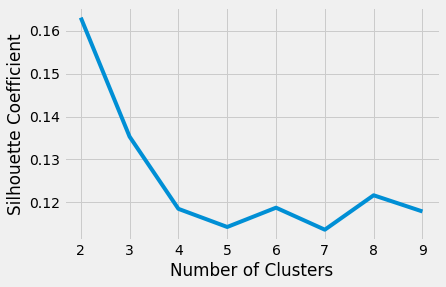

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Only works for 2 and above clusters as assesses inter-centroid distance
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, init='k-means++')
    kmeans.fit(ecmodf_normalized)
    score = silhouette_score(ecmodf_normalized, kmeans.labels_)
    silhouette_coefficients.append(score)
    
plt.style.use("fivethirtyeight")
plt.plot(range(2, 10), silhouette_coefficients)
plt.xticks(range(2, 10))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [10]:
from validclust.validclust import ValidClust #rapid assessment of optimal k using multiple tests

data_temp = ecmodf_normalized.to_numpy()
vclust = ValidClust(k=list(range(2, 9)), methods=['kmeans'])

cvi_vals = vclust.fit_predict(data_temp)
print(cvi_vals)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function 

                           2         3         4         5         6  \
method index                                                           
kmeans silhouette   0.163072  0.135242  0.121872  0.129470  0.099451   
       calinski    11.740990  9.455885  8.544322  7.732050  6.931686   
       davies       1.991777  1.882923  2.052850  1.922900  1.889159   
       dunn         0.372135  0.301947  0.319324  0.378334  0.378068   

                          7         8  
method index                           
kmeans silhouette  0.125644  0.132080  
       calinski    6.699842  6.533174  
       davies      1.683722  1.631797  
       dunn        0.350506  0.441733  


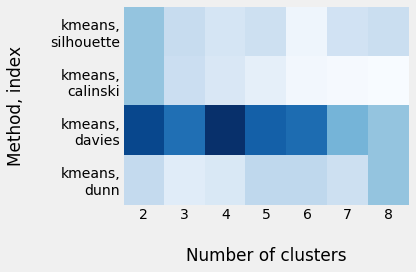

In [11]:
vclust.plot() # darker cells indicate higher quality clustering

## cluster prediction strength 

In [12]:
## https://towardsdatascience.com/prediction-strength-a-simple-yet-relatively-unknown-way-to-evaluate-clustering-2e5eaf56643
## Tibshirani R, Walther G. Cluster validation by prediction strength. J Comput Graph Stat 2005; 3: 511e28
## Used in 10.1016/j.bja.2019.02.026

In [13]:
import sys

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from scipy.spatial import distance

import matplotlib.pyplot as plt
import seaborn as sns 
plt.style.use('seaborn')

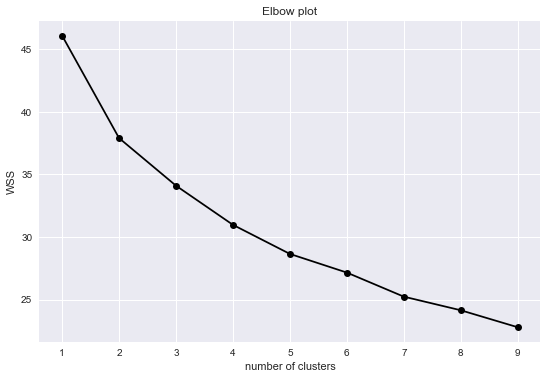

In [14]:
# setting the range of k
clusters = range(1, 10)

# running the clustering 
wss_list = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(ecmodf_normalized)
    wss_list.append(model.inertia_)

# plotting
_, ax = plt.subplots()
ax.plot(clusters, wss_list, '-o', color='black')
ax.set(title='Elbow plot', 
       xlabel='number of clusters', 
       ylabel='WSS');

In [15]:
temp2 = ecmodf_normalized.copy()
temp2.head()

,age,bmi,ed_v,v_vv,sofa,pfr,pco2,pplat,lymph,nlrat,pct,ferritin,crp,fib,ddim
0,0.510,0.516065,0.282727,0.260,0.010000,0.164412,0.053777,0.648269,0.311030,0.669388,0.267444,0.503267,0.461908,0.485610,0.505096
1,0.210,0.614365,0.555455,0.135,0.010000,0.572500,0.288401,0.671757,0.407940,0.743612,0.569678,0.080622,0.326031,0.107561,1.010000
2,1.010,0.204203,0.555455,0.135,0.670964,0.353073,0.158407,0.601307,0.186091,0.607728,0.584579,0.701147,0.619160,0.473415,1.010000
3,0.210,0.582513,0.010000,0.260,0.302481,0.509081,0.130426,0.693640,0.987724,0.410162,0.331078,0.215550,0.587099,0.473415,0.423650
4,0.685,0.761716,0.100909,0.260,0.802481,0.636225,0.253328,0.737523,0.612060,0.336526,1.010000,0.714711,1.010000,0.327073,0.988456


In [16]:
# train/test split
data_temp2 = ecmodf_normalized.to_numpy()
X_train, X_test = train_test_split(data_temp2, test_size=0.3, shuffle=True, random_state=42)

In [17]:
## helper function to define closest centroid to given observation

def get_closest_centroid(obs, centroids):
    '''
    Function for retrieving the closest centroid to the given observation 
    in terms of the Euclidean distance.
    
    Parameters
    ----------
    obs : array
        An array containing the observation to be matched to the nearest centroid
    centroids : array
        An array containing the centroids
    
    Returns
    -------
    min_centroid : array
        The centroid closes to the obs 
    '''
    min_distance = sys.float_info.max
    min_centroid = 0
    
    for c in centroids:
        dist = distance.euclidean(obs, c)
        if dist < min_distance:
            min_distance = dist
            min_centroid = c
            
    return min_centroid

In [18]:
## main function that determines prediction strength of each cluster

def get_prediction_strength(k, train_centroids, x_test, test_labels):
    '''
    Function for calculating the prediction strength of clustering
    
    Parameters
    ----------
    k : int
        The number of clusters
    train_centroids : array
        Centroids from the clustering on the training set
    x_test : array
        Test set observations
    test_labels : array
        Labels predicted for the test set
        
    Returns
    -------
    prediction_strength : float
        Calculated prediction strength
    '''
    n_test = len(x_test)
    
    # populate the co-membership matrix
    D = np.zeros(shape=(n_test, n_test))
    for x1, l1, c1 in zip(x_test, test_labels, list(range(n_test))):
        for x2, l2, c2 in zip(x_test, test_labels, list(range(n_test))):
            if tuple(x1) != tuple(x2):
                if tuple(get_closest_centroid(x1, train_centroids)) == tuple(get_closest_centroid(x2, train_centroids)):
                    D[c1,c2] = 1.0
    
    # calculate the prediction strengths for each cluster
    ss = []
    for j in range(k):
        s = 0
        examples_j = x_test[test_labels == j, :].tolist()
        n_examples_j = len(examples_j)
        for x1, l1, c1 in zip(x_test, test_labels, list(range(n_test))):
            for x2, l2, c2 in zip(x_test, test_labels, list(range(n_test))):
                if tuple(x1) != tuple(x2) and l1 == l2 and l1 == j:
                    s += D[c1,c2]
        ss.append(s / (n_examples_j * (n_examples_j - 0.9999))) 

    prediction_strength = min(ss)

    return prediction_strength

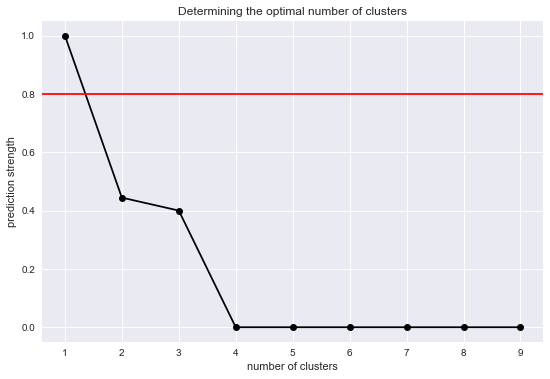

In [19]:
# running the clustering 
strengths = []
for k in clusters:
    model_train = KMeans(n_clusters=k, random_state=42).fit(X_train)
    model_test = KMeans(n_clusters=k, random_state=42).fit(X_test)
    
    pred_str = get_prediction_strength(k, model_train.cluster_centers_, X_test, model_test.labels_)
    strengths.append(pred_str)

# plotting
_, ax = plt.subplots()
ax.plot(clusters, strengths, '-o', color='black')
ax.axhline(y=0.8, c='red');
ax.set(title='Determining the optimal number of clusters', 
       xlabel='number of clusters', 
       ylabel='prediction strength');

##Should select maximum cluster for which prediction strength is above certain theshold (i.e. 3 in this case)

## cluster prediction - different implementation

In [20]:
from reval.best_nclust_cv import FindBestClustCV #https://reval.readthedocs.io/en/latest/code_usage.html for finding best number of clusters

##can't get working currently - similar method to above

## elbow and gap statistic

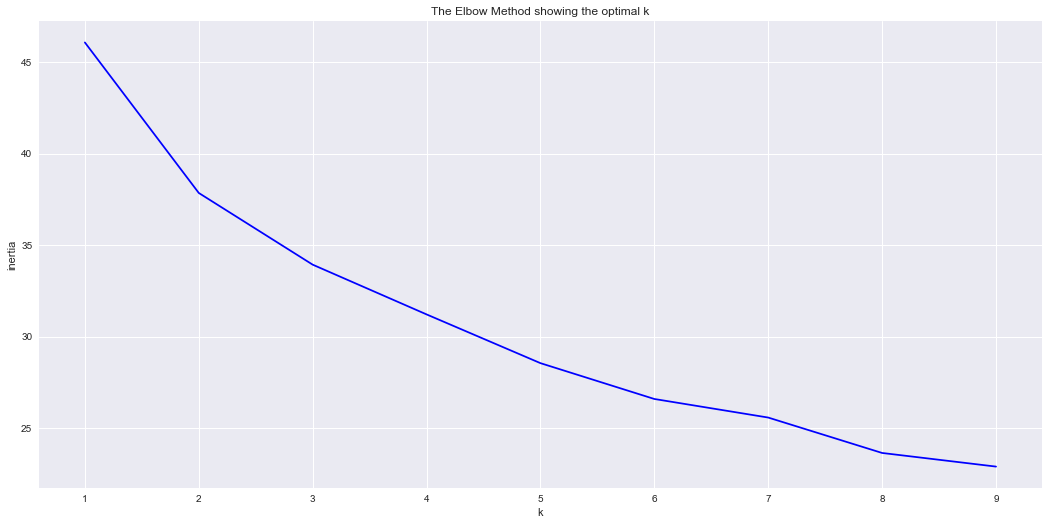

In [21]:
inertia = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, init='k-means++')
    kmeanModel.fit(ecmodf_normalized)
    inertia.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [22]:
from kneed import KneeLocator

kl = KneeLocator(
    range(1, 10), inertia, curve="convex", direction="decreasing"
)

kl.elbow

3

In [23]:
from gap_statistic import OptimalK

optimalK = OptimalK(parallel_backend=None) #THIS CAN USE MULTICORES!!!!!! backend=rust / backend = multiprocessing
optimalK

OptimalK(n_jobs=1, parallel_backend="None")

In [24]:
n_clusters = optimalK(ecmodf_normalized, cluster_array=np.arange(1, 10))
print('Optimal clusters: ', n_clusters)

Optimal clusters:  5


In [25]:
optimalK.gap_df

,n_clusters,gap_value,gap*,ref_dispersion_std,sk,sk*,diff,diff*
0,1.0,0.390596,22.029155,1.038495,0.017697,25.465327,-0.039874,25.446485
1,2.0,0.435517,22.077363,0.273078,0.005047,25.494693,-0.020564,25.511305
2,3.0,0.488355,21.768824,1.582039,0.032274,25.202766,0.010940,25.188238
3,4.0,0.514609,21.594178,1.717934,0.037195,25.013592,-0.020076,25.325551
4,5.0,0.581028,23.405883,2.118404,0.046343,27.137256,0.113994,26.685047
5,6.0,0.523234,20.098792,2.436222,0.056200,23.377956,-0.035449,23.266402
6,7.0,0.574308,20.402843,0.631397,0.015625,23.570452,0.095322,23.331671
7,8.0,0.518250,18.458742,1.531660,0.039264,21.387571,0.048238,21.276309
8,9.0,0.521167,17.463582,1.875381,0.051155,20.281149,NaN,NaN


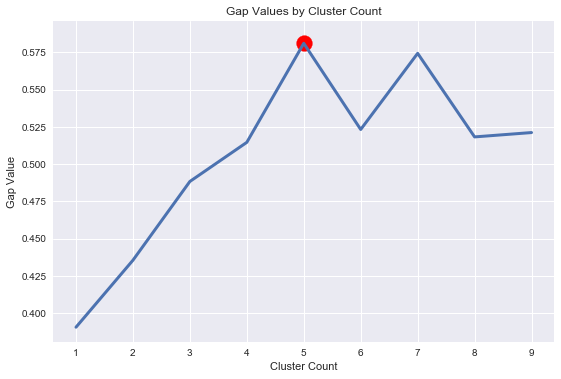

In [26]:
plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=3)
plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].n_clusters,
            optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].gap_value, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

[[0.62730769 0.36729939 0.12888112 0.68307692 0.65540981 0.38993967
  0.29778935 0.72705861 0.58405746 0.45934234 0.77522772 0.59372564
  0.64440986 0.59348968 0.75215341]
 [0.37964286 0.35225308 0.22379663 0.57696429 0.19123505 0.5705976
  0.2110623  0.65505767 0.66240037 0.45747528 0.36322923 0.45397889
  0.36343511 0.45381533 0.42036611]
 [0.60166667 0.49619042 0.46454545 0.16833333 0.30424116 0.3659415
  0.26770675 0.59021363 0.357301   0.66806162 0.45239887 0.56729341
  0.41264631 0.33439024 0.61284153]]


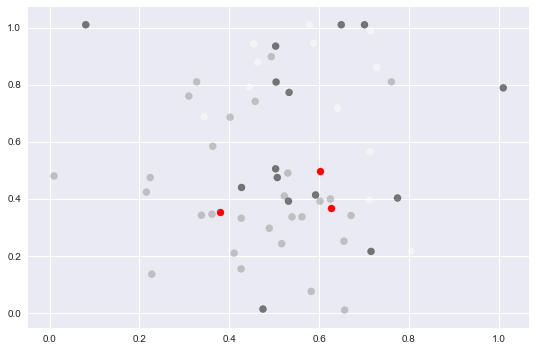

In [27]:
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=1000, n_jobs=-1).fit(ecmodf_normalized)
centroids = kmeans.cluster_centers_
print(centroids)

plt.scatter(ecmodf_normalized['ferritin'], ecmodf_normalized['ddim'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

In [28]:
pred = kmeans.predict(ecmodf_normalized)
ecmodf_clustered = pd.DataFrame(ecmodf)
ecmodf_clustered['cluster'] = pred

In [29]:
ecmodf_clustered['cluster'].value_counts() #counts numbers in each cluster

1    28
2    15
0    13
Name: cluster, dtype: int64

In [30]:
ecmodf_clustered

,age,bmi,ed_v,v_vv,sofa,pfr,pco2,pplat,lymph,nlrat,pct,ferritin,crp,fib,ddim,cluster
id,,,,,,,,,,,,,,,,
1,46.0,34,3.000000,2.0,4.0,48.750000,6.000000,29.000000,0.4,24.000000,0.800000,1609.0,306.0,7.2,10.30000,2
2,34.0,37,6.000000,1.0,4.0,76.500000,10.044650,29.513452,0.5,31.200000,5.709137,115.0,217.0,4.1,80.00000,2
3,66.0,26,6.000000,1.0,10.0,61.578947,7.550000,28.000000,0.3,19.300000,6.290000,5534.0,409.0,7.1,80.00000,2
4,34.0,36,0.000000,2.0,6.0,72.187500,7.100000,30.000000,1.9,9.600000,1.210000,267.0,388.0,7.1,7.40000,1
5,53.0,42,1.000000,2.0,12.0,80.833333,9.300000,31.000000,0.8,7.400000,100.000000,6023.0,665.0,5.9,73.30000,0
6,55.0,28,3.000000,6.0,4.0,66.000000,12.000000,30.000000,0.4,22.500000,6.430000,3800.0,460.0,10.0,24.40000,0
7,52.0,26,0.000000,7.0,10.0,68.250000,14.000000,32.000000,0.7,14.400000,17.220000,1253.0,355.0,7.8,46.90000,0
8,57.0,22,0.000000,5.0,9.0,67.500000,9.000000,27.000000,0.9,11.100000,9.540000,1903.0,596.0,11.5,31.20000,0
9,53.0,27,1.000000,6.0,13.0,65.250000,11.500000,26.000000,1.8,8.300000,55.650000,6561.0,355.0,6.6,43.70000,0
